
Circuit Simulation Example with OBI-One
======================================

This notebook demonstrates how to run circuit simulations using the obi-one simulation framework
with [BlueCelluLab](https://github.com/openbraininstitute/BlueCelluLab) as the simulator. Let's get the path to the simulation configuration and circuit configuration file paths and the population name of the circuit that you want to simulate.

For this example, we will use the pre-made `simulation_config.json` (simulation configuration) file instead of the one generated by obi-one.

In [1]:
population_name = "S1nonbarrel_neurons"
# circuit_folder = "../data/tiny_circuits/N_10__top_nodes_dim6__asc"
# circuit_config_path = "../data/tiny_circuits/N_10__top_nodes_dim6__asc/circuit_config.json"
# simulation_config_path = "../data/tiny_circuits/N_10__top_nodes_dim6__asc/simulation_config.json"

circuit_folder = "/Users/mandge/Desktop/circuit_simulation/obi-one/examples/data/tiny_circuits/N_10__top_nodes_dim6__asc/"
circuit_config_path = "/Users/mandge/Desktop/circuit_simulation/obi-one/examples/data/tiny_circuits/N_10__top_nodes_dim6__asc/circuit_config.json"
# Simualtion config is the only input needed
simulation_config_path = "/Users/mandge/Desktop/circuit_simulation/obi-one/examples/data/tiny_circuits/N_10__top_nodes_dim6__asc/simulation_config.json"

# population_name = "S1nonbarrel_neurons"
# circuit_folder = "../data/tiny_circuits/nbS1-O1-vSub-nCN-HEX0-L1-01"
# circuit_config_path = "../data/tiny_circuits/nbS1-O1-vSub-nCN-HEX0-L1-01/circuit_config.json"
# simulation_config_path = "../data/tiny_circuits/nbS1-O1-vSub-nCN-HEX0-L1-01/simulation_config.json"

# hippocampus
# population_name = "hippocampus_neurons"
# circuit_folder = "/Users/mandge/Desktop/circuit_simulation/obi-one/examples/data/tiny_circuits/N_10__rCA1-ThetaOsc-Sel1__swc"
# circuit_config_path="/Users/mandge/Desktop/circuit_simulation/obi-one/examples/data/tiny_circuits/N_10__rCA1-ThetaOsc-Sel1__swc/circuit_config.json"
# simulation_config_path="/Users/mandge/Desktop/circuit_simulation/obi-one/examples/data/tiny_circuits/N_10__rCA1-ThetaOsc-Sel1__swc/simulation_config.json"

Get the path to the mod files and compile the mod files. 

In [ ]:
! rm -r arm64/
!nrnivmodl -incflags "-DDISABLE_REPORTINGLIB" {circuit_folder}/mod 
# !nrnivmodl {circuit_folder}/mod

Import required modules from obi-one

In [ ]:

from obi_one.scientific.simulation.simulations import Simulation
# The imports below will be used when simulation config is created using obi-one
from obi_one.scientific.simulation.stimulus import ConstantCurrentClampSomaticStimulus
from obi_one.scientific.simulation.recording import SomaVoltageRecording
from obi_one.scientific.simulation.timestamps import RegularTimestamps
from obi_one.scientific.circuit.neuron_sets import IDNeuronSet
from obi_one.core.tuple import NamedTuple
from obi_one.scientific.unions.unions_neuron_sets import NeuronSetReference
from obi_one.scientific.unions.unions_timestamps import TimestampsReference
from matplotlib import pyplot as plt


Create the `Simulation` object.

In [4]:
# Create regular timestamps with start, end, and dt
timestamps = RegularTimestamps(
    number_of_repetitions=1, 
    interval=100.0,  # ms
    start_time=0.0,  # ms
    end_time=100.0,  # ms
    dt=0.1,          # ms
    simulation_level_name="timestamps_1"
)

# Create a NamedTuple with the neuron IDs
neuron_ids = NamedTuple(name="neuron_ids", elements=[1, 2, 3])  # List of cell IDs to include

# Create neuron set using IDNeuronSet
neuron_set = IDNeuronSet(
    population=population_name, 
    neuron_ids=neuron_ids,
    simulation_level_name="neuron_set_1"
)

# First, create the timestamps reference
timestamps_ref = TimestampsReference(block=timestamps, block_name="timestamps_1")

# Then create the stimulus with the reference
stimulus = ConstantCurrentClampSomaticStimulus(
    timestamps=timestamps_ref,
    delay=10.0,  # ms
    duration=50.0,  # ms
    amplitude=0.1,  # nA
    neuron_set=NeuronSetReference(block=neuron_set, block_name="neuron_set_1"),
    simulation_level_name="stimulus_1"
)
# Create recordings (example with voltage recording)
recording = SomaVoltageRecording(
    start_time=0.0,
    end_time=100.0,
    dt=0.1,
    neuron_set=NeuronSetReference(block=neuron_set, block_name="neuron_set_1"),
    simulation_level_name="voltage_recording_1"
)

from obi_one.scientific.circuit.circuit import Circuit

# First create the circuit object
circuit = Circuit(
    name="N_10__top_nodes_dim6__asc",
    path=circuit_config_path,
    node_population=population_name,
)

from obi_one.core.info import Info
# Create info object
simulation_info = Info(
    name="N_10__top_nodes_dim6__asc Simulation",
    description="A test simulation with a small microcircuit",
    author="Darshan Mandge",
    version="0.0.1"
)

# Then use it in the simulation initialization
simulation = Simulation(
    name="simulation_1",
    info=simulation_info,
    timestamps={"timestamps_1": timestamps},  # Make sure this matches the block_name
    stimuli={"stimulus_1": stimulus},
    recordings={"voltage_recording_1": recording},
    neuron_sets={"neuron_set_1": neuron_set},
    initialize={
        "circuit": circuit,
        "simulation_length": 100.0,  # ms
        "node_set": NeuronSetReference(block=neuron_set, block_name="neuron_set_1"),
        "timestep": 0.025  # ms
    }
)

If you want to generate configuration uncomment the cell below.

In [5]:
# Generate the simulation configuration
# simulation.generate()å

Provide a list of gid (cells ids) from the circuit to simulate

In [6]:
# gids_to_simulate = [0,1,2,3,4,5,6,7,8,9]

# gids_to_simulate = [0,1,2,3,4,5,6,7]

We pass `cell_ids` as list of of gid `(population_name, gid)`

In [7]:
# create for each gid (population_name, gid)
# cell_ids is list of these tuples
# cell_idids.apps = []
# for gid in gids_to_simulate:
#     cell_end((population_name, gid))
    

Run circuit simulation using BlueCelluLab backend. In future, we will support Neurodamus backend as well. This will run a SONATA simulation and save voltage traces for the specified cells.  

In [8]:
# Run the simulation
simulation.run(
    simulation_config=simulation_config_path,
    simulator="bluecellulab", # Optional: bluecellulab or neurodamus. Default: bluecellulab
    save_nwb=False            # Optional: Save results in NWB format. Default: False
    )

2025-06-24 08:55:18,843 - obi_one.scientific.simulation.simulations.Simulation - INFO - Starting simulation with bluecellulab backend
numprocs=1
2025-06-24 08:55:18,913 - obi_one.scientific.simulation.execution - INFO - Initializing BlueCelluLab simulation
2025-06-24 08:55:18,913 - obi_one.scientific.simulation.execution - INFO - sim_config_base_dir: /Users/mandge/Desktop/circuit_simulation/obi-one/examples/data/tiny_circuits/N_10__top_nodes_dim6__asc
2025-06-24 08:55:18,914 - obi_one.scientific.simulation.execution - INFO - OUTPUT_DIR: .
2025-06-24 08:55:18,914 - obi_one.scientific.simulation.execution - INFO - node_sets_file: /Users/mandge/Desktop/circuit_simulation/obi-one/examples/data/tiny_circuits/N_10__top_nodes_dim6__asc/node_sets.json
2025-06-24 08:55:18,915 - obi_one.scientific.simulation.execution - INFO - Population: S1nonbarrel_neurons
2025-06-24 08:55:18,915 - obi_one.scientific.simulation.execution - INFO - All node IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
2025-06-24 08:55:18

The results are stored in the output directory of the circuit folder. The logs are also stored in the logs in notebooks folder.

### Spike Report Analysis using BluePySnap

We will use the example [notebook](https://github.com/openbraininstitute/snap/blob/master/doc/source/notebooks/06_spike_reports.ipynb) from BluePySnap to analyse the spike report generated by the circuit simulation.

In [9]:
import bluepysnap

snap_simulation = bluepysnap.Simulation(simulation_config_path)
spikes = snap_simulation.spikes
print(
    spikes.time_start,
    spikes.time_stop, 
    spikes.dt
)
print(spikes.population_names)

0 3000.0 0.025
['S1nonbarrel_neurons']


In [10]:
snap_simulation.config

{'conditions': {'extracellular_calcium': 1.1,
  'mechanisms': {'ProbAMPANMDA_EMS': {'init_depleted': True,
    'minis_single_vesicle': True},
   'ProbGABAAB_EMS': {'init_depleted': True, 'minis_single_vesicle': True}},
  'spike_location': 'soma',
  'v_init': -80.0},
 'inputs': {'IStim_0': {'amp_end': 1.0,
   'amp_start': 0.5,
   'delay': 0.0,
   'duration': 5.0,
   'input_type': 'current_clamp',
   'module': 'linear',
   'node_set': 'hex0',
   'represents_physical_electrode': False},
  'IStim_1': {'amp_end': 0.5,
   'amp_start': 0.5,
   'delay': 1000.0,
   'duration': 5.0,
   'input_type': 'current_clamp',
   'module': 'linear',
   'node_set': 'hex0',
   'represents_physical_electrode': False},
  'IStim_2': {'amp_end': 0.5,
   'amp_start': 0.5,
   'delay': 2000.0,
   'duration': 5.0,
   'input_type': 'current_clamp',
   'module': 'linear',
   'node_set': 'hex0',
   'represents_physical_electrode': False}},
 'network': '/Users/mandge/Desktop/circuit_simulation/obi-one/examples/data/tiny

In [11]:
spike_pop = spikes['S1nonbarrel_neurons']
print(type(spike_pop))

node_population = spike_pop.nodes
print(f'{node_population.name}: {type(node_population)}')

<class 'bluepysnap.spike_report.PopulationSpikeReport'>
S1nonbarrel_neurons: <class 'bluepysnap.nodes.node_population.NodePopulation'>


ids = spike_pop.node_ids
node_population.get(ids, properties=['layer','synapse_class','x','y','z']).head()

In [12]:
filtered = spikes.filter(group={'layer':'6'}, t_start=spikes.time_start, t_stop=spikes.time_stop)
filtered.report.head()

,ids,population
times,,
1.000000e-10,9,S1nonbarrel_neurons
1.000000e-10,8,S1nonbarrel_neurons
1.000000e-10,7,S1nonbarrel_neurons
1.000000e-10,6,S1nonbarrel_neurons
1.000000e-10,4,S1nonbarrel_neurons


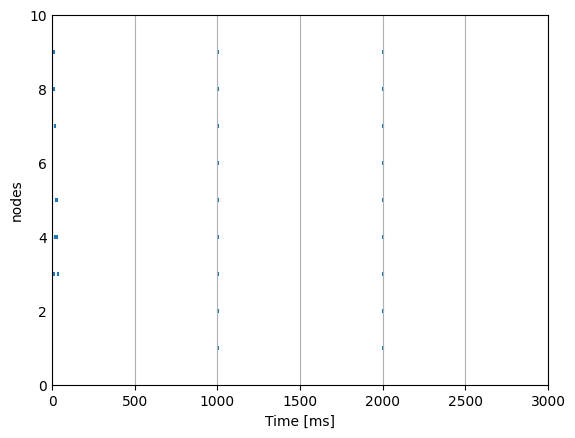

In [13]:
filtered.raster();

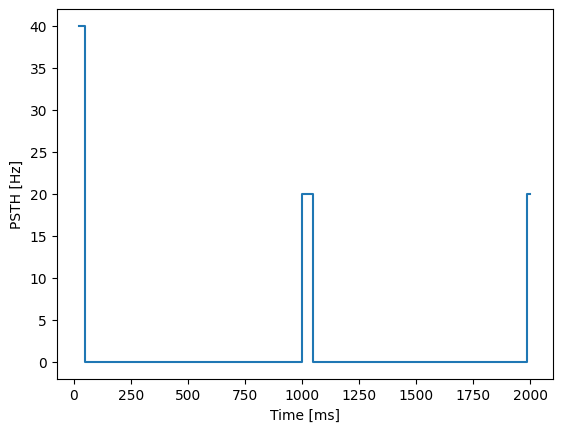

In [14]:
filtered.firing_rate_histogram();

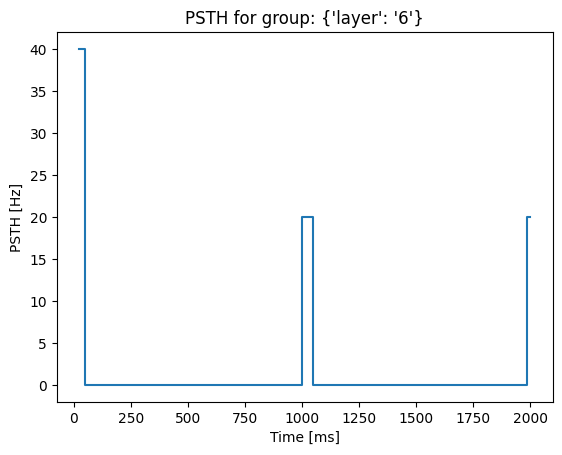

In [15]:
import matplotlib.pyplot as plt
import numpy as np

ax = plt.gca()
ax.set_xlabel("Time [ms]")
ax.set_ylabel("PSTH [Hz]")
ax.set_title(f"PSTH for group: {filtered.group}")

times = filtered.report.index

time_start = np.min(times)
time_stop = np.max(times)

# heuristic for a nice bin size (~100 spikes per bin on average)
time_binsize = min(50.0, (time_stop - time_start) / ((len(times) / 100.0) + 1.0))

bins = np.append(np.arange(time_start, time_stop, time_binsize), time_stop)
hist, bin_edges = np.histogram(times, bins=bins)
node_count = len(snap_simulation.circuit.nodes.ids(filtered.group))  # Get length of node ids for whole `group`
freq = 1.0 * hist / node_count / (0.001 * time_binsize)

# use the middle of the bins instead of the start of the bin
ax.plot(0.5 * (bin_edges[1:] + bin_edges[:-1]), freq, label="PSTH", drawstyle="steps-mid");

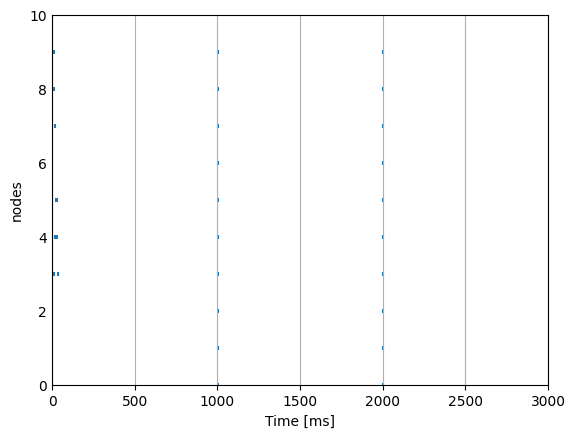

In [16]:
spikes.filter().raster();

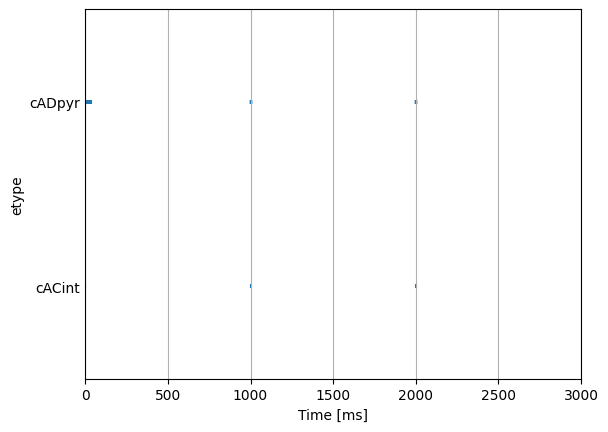

In [17]:
spikes.filter().raster(y_axis='etype');

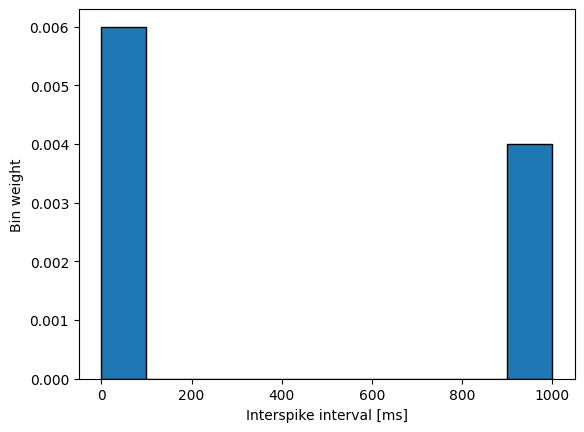

In [18]:
spikes.filter().isi(binsize=100);

### Soma Report Analysis

Let's [load](https://github.com/openbraininstitute/snap/blob/master/doc/source/notebooks/07_frame_reports.ipynb) the soma report using BluePySnap and plot it.

In [19]:
snap_simulation.reports

{'SomaVoltRec': <bluepysnap.frame_report.SomaReport at 0x3434e8b60>}

In [20]:
soma_report = snap_simulation.reports['SomaVoltRec']

In [21]:
print(
    soma_report.time_start, 
    soma_report.time_stop, 
    soma_report.dt,
    soma_report.time_units
)  # Gives a warning in case the dt differs from simulation.dt

2025-06-24 08:56:30,179 - bluepysnap.frame_report - WARNING - dt from the report differs from the global simulation dt.
0.0 3000.0 0.1 ms


In [22]:
soma_report.population_names

['S1nonbarrel_neurons']

In [23]:
soma_pop = soma_report['S1nonbarrel_neurons']
print(type(soma_pop))

<class 'bluepysnap.frame_report.PopulationSomaReport'>


In [24]:
node_population = soma_pop.nodes
print(f'{node_population.name}: {type(node_population)}')

S1nonbarrel_neurons: <class 'bluepysnap.nodes.node_population.NodePopulation'>


In [25]:
ids = soma_pop.node_ids
node_population.get(ids, properties=['layer','synapse_class','x','y','z']).head()

,layer,synapse_class,x,y,z
node_ids,,,,,
0,3,INH,4426.676668,-1365.720303,-1999.555547
1,6,EXC,3704.584482,-1105.618485,-2859.425448
2,6,EXC,3592.573893,-1084.057134,-2963.768280
3,6,EXC,3627.362786,-1087.181103,-2897.810749
4,6,EXC,3537.776871,-1029.445880,-2890.783793


In [26]:
filtered = soma_report.filter(group={'layer':'6'}, t_start= soma_report.time_start, t_stop= soma_report.time_stop)
filtered.report.head()

S1nonbarrel_neurons                                              \
                      1          2          3          4          5   
0.0            0.025000   0.025000   0.025000   0.025000   0.025000   
0.1          -75.012161 -81.421906 -74.164589 -73.334396 -73.318329   
0.2          -80.971519 -85.563881 -80.190681 -78.139061 -78.128128   
0.3          -82.381752 -86.438622 -81.931999 -79.541733 -79.488579   
0.4          -82.900101 -86.714569 -82.654526 -80.193848 -80.091064   

                                                 
             6          7          8          9  
0.0   0.025000   0.025000   0.025000   0.025000  
0.1 -72.265778 -68.949173 -75.983292 -74.589790  
0.2 -78.832153 -75.408142 -80.140320 -79.929703  
0.3 -80.837555 -77.539986 -81.345116 -81.573647  
0.4 -81.695602 -78.492760 -81.851669 -82.339790

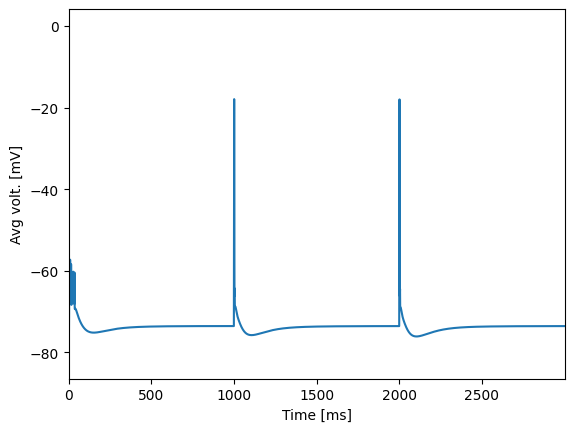

In [27]:
filtered.trace();

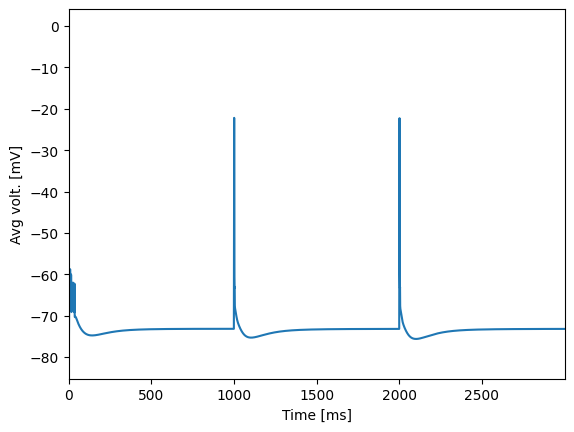

In [28]:
soma_report.filter().trace();